# Jitter Buffer Delay box plots

Depends on the output from the [ExtractRawData](./ExtractRawData.ipynb) notebook.

For all the successful calls, For both clients (Alice, Bob) find the [JitterBufferDelay](https://www.w3.org/TR/webrtc-stats/#dom-rtcinboundrtpstreamstats-jitterbufferdelay) and [JitterBufferEmittedCount](https://www.w3.org/TR/webrtc-stats/#dom-rtcinboundrtpstreamstats-jitterbufferemittedcount) values from the WebRTC stat `inbound-rtp` for both video and audio, divide the two values to calculate the average jitter 

Plot the data.

Outputs the following:

- `output_folder/avgJitterBufferDelayPlotDf.csv`. The data used for the plot with headers: `scenario, client, mediaType, avgJitterBufferDelay`
- Box plot [BoxPlotAvgJitterBufferDelayVideo.png](./output_folder/BoxPlotAvgJitterBufferDelayVideo.png)
- Box plot [BoxPlotAvgJitterBufferDelayVideo.svg](./output_folder/BoxPlotAvgJitterBufferDelayVideo.svg)
- Box plot [BoxPlotAvgJitterBufferDelayAudio.png](./output_folder/BoxPlotAvgJitterBufferDelayAudio.png)
- Box plot [BoxPlotAvgJitterBufferDelayAudio.svg](./output_folder/BoxPlotAvgJitterBufferDelayAudio.svg)

In [1]:
import sys
from dotenv import load_dotenv
from datetime import datetime, timedelta
import pandas as pd
import os
import json
import logging
import matplotlib.pyplot as plt
import helperFunctions as hf
import numpy as np

hf.setup()

callAndOutcomeFile = "output_folder/UniqueCallsAndOutcomes.csv"
outputFolder = "output_folder/"


if not os.path.exists(outputFolder):

   # Create a new directory because it does not exist
   os.makedirs(outputFolder)
   logging.info(f"The directory \"{outputFolder}\" is created!")

In [2]:
df = pd.DataFrame(columns=["scenario", "client", "mediaType", "avgJitterBufferDelay"])

callsDf = pd.read_csv(callAndOutcomeFile)

# filter for calls with state success
successCallsDf = callsDf.loc[callsDf["logging_type"] == "COMMAND_SESSION_SUCCESS"]

for scenario in hf.scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  logging.info(f"Starting on scenario {s}, alice: {a}, bob: {b}")

  # filter for calls with scenario_type s
  scenarioCallsDf = successCallsDf.loc[successCallsDf["scenario_type"] == s]

  # get list of room_ids in scenarioCallsDf
  roomIds = scenarioCallsDf["room_id"].unique()

  reportForClientA = pd.read_csv(f"output_folder/rawReport/{a}.csv")

  # Video Client A
  JitterBufferDelay = reportForClientA[(reportForClientA["type"] == "inbound-rtp") & (reportForClientA["roomId"].isin(roomIds)) & (reportForClientA["mediaType"] == "video") & (reportForClientA["jitterBufferDelay"] > 0)  & (reportForClientA["jitterBufferEmittedCount"] > 0)  ]["jitterBufferDelay"]
  JitterBufferEmittedCount = reportForClientA[(reportForClientA["type"] == "inbound-rtp") & (reportForClientA["roomId"].isin(roomIds)) & (reportForClientA["mediaType"] == "video") & (reportForClientA["jitterBufferDelay"] > 0)  & (reportForClientA["jitterBufferEmittedCount"] > 0)  ]["jitterBufferEmittedCount"]
  avgJitterBufferDelay = JitterBufferDelay / JitterBufferEmittedCount
  dataVideoA = pd.DataFrame(columns=["scenario", "client", "mediaType", "avgJitterBufferDelay"]).assign(avgJitterBufferDelay=avgJitterBufferDelay)
  dataVideoA = dataVideoA.assign(scenario=s, client=a, mediaType="video")

  # Audio Client A
  JitterBufferDelay = reportForClientA[(reportForClientA["type"] == "inbound-rtp") & (reportForClientA["roomId"].isin(roomIds)) & (reportForClientA["mediaType"] == "audio") & (reportForClientA["jitterBufferDelay"] > 0)  & (reportForClientA["jitterBufferEmittedCount"] > 0)  ]["jitterBufferDelay"]
  JitterBufferEmittedCount = reportForClientA[(reportForClientA["type"] == "inbound-rtp") & (reportForClientA["roomId"].isin(roomIds)) & (reportForClientA["mediaType"] == "audio") & (reportForClientA["jitterBufferDelay"] > 0)  & (reportForClientA["jitterBufferEmittedCount"] > 0)  ]["jitterBufferEmittedCount"]
  avgJitterBufferDelay = JitterBufferDelay / JitterBufferEmittedCount
  dataAudioA = pd.DataFrame(columns=["scenario", "client", "mediaType", "avgJitterBufferDelay"]).assign(avgJitterBufferDelay=avgJitterBufferDelay)
  dataAudioA = dataAudioA.assign(scenario=s, client=a, mediaType="audio")

  # Remove inputs where 


  reportForClientB = pd.read_csv(f"output_folder/rawReport/{b}.csv")

  # Video Client B
  JitterBufferDelay = reportForClientB[(reportForClientB["type"] == "inbound-rtp") & (reportForClientB["roomId"].isin(roomIds)) & (reportForClientB["mediaType"] == "video") & (reportForClientB["jitterBufferDelay"] > 0)  & (reportForClientB["jitterBufferEmittedCount"] > 0) ]["jitterBufferDelay"]
  JitterBufferEmittedCount = reportForClientB[(reportForClientB["type"] == "inbound-rtp") & (reportForClientB["roomId"].isin(roomIds)) & (reportForClientB["mediaType"] == "video") & (reportForClientB["jitterBufferDelay"] > 0)  & (reportForClientB["jitterBufferEmittedCount"] > 0) ]["jitterBufferEmittedCount"]
  avgJitterBufferDelay = JitterBufferDelay / JitterBufferEmittedCount
  dataVideoB = pd.DataFrame(columns=["scenario", "client", "mediaType", "avgJitterBufferDelay"]).assign(avgJitterBufferDelay=avgJitterBufferDelay)
  dataVideoB = dataVideoB.assign(scenario=s, client=b, mediaType="video")

  # Audio Client B
  JitterBufferDelay = reportForClientB[(reportForClientB["type"] == "inbound-rtp") & (reportForClientB["roomId"].isin(roomIds)) & (reportForClientB["mediaType"] == "audio") & (reportForClientB["jitterBufferDelay"] > 0)  & (reportForClientB["jitterBufferEmittedCount"] > 0) ]["jitterBufferDelay"]
  JitterBufferEmittedCount = reportForClientB[(reportForClientB["type"] == "inbound-rtp") & (reportForClientB["roomId"].isin(roomIds)) & (reportForClientB["mediaType"] == "audio") & (reportForClientB["jitterBufferDelay"] > 0)  & (reportForClientB["jitterBufferEmittedCount"] > 0) ]["jitterBufferEmittedCount"]
  avgJitterBufferDelay = JitterBufferDelay / JitterBufferEmittedCount
  dataAudioB = pd.DataFrame(columns=["scenario", "client", "mediaType", "avgJitterBufferDelay"]).assign(avgJitterBufferDelay=avgJitterBufferDelay)
  dataAudioB = dataAudioB.assign(scenario=s, client=b, mediaType="audio")

  df = pd.concat([df, dataVideoA, dataAudioA, dataVideoB, dataAudioB], ignore_index=True)

logging.info(f"df shape: {df.shape}")

# save plotDf to csv
df.to_csv(f"{outputFolder}/avgJitterBufferDelayPlotDf.csv",index=False, header=True, encoding='utf-8', mode='w')


2023-02-01 15:46:06 INFO     Starting on scenario 1, alice: c1-Normal, bob: d1-Normal 
2023-02-01 15:46:14 INFO     Starting on scenario 2, alice: c2-TorNormal, bob: d2-TorNormal 
2023-02-01 15:46:19 INFO     Starting on scenario 3, alice: c3-TorEurope, bob: d3-TorEurope 
2023-02-01 15:46:25 INFO     Starting on scenario 4, alice: c4-TorScandinavia, bob: d4-TorScandinavia 
2023-02-01 15:46:30 INFO     Starting on scenario 5, alice: c6-Lokinet, bob: d6-Lokinet 
2023-02-01 15:46:33 INFO     Starting on scenario 6, alice: c1-Normal, bob: d2-TorNormal 
2023-02-01 15:46:40 INFO     Starting on scenario 7, alice: c2-TorNormal, bob: d1-Normal 
2023-02-01 15:46:46 INFO     Starting on scenario 8, alice: c1-Normal, bob: d3-TorEurope 
2023-02-01 15:46:51 INFO     Starting on scenario 9, alice: c3-TorEurope, bob: d1-Normal 
2023-02-01 15:46:57 INFO     Starting on scenario 10, alice: c1-Normal, bob: d4-TorScandinavia 
2023-02-01 15:47:03 INFO     Starting on scenario 11, alice: c4-TorScandinavia,

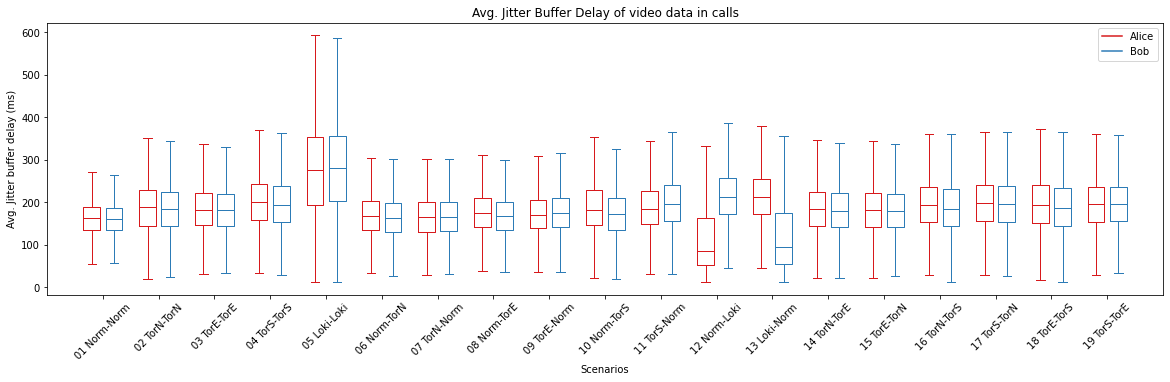

In [5]:
dataA = []
dataB = []
for scenario in hf.scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  dataA.append(df.loc[(df["scenario"] == s) & (df["mediaType"] == "video") & (df["client"] == a)]["avgJitterBufferDelay"].values * 1000)
  dataB.append(df.loc[(df["scenario"] == s) & (df["mediaType"] == "video") & (df["client"] == b)]["avgJitterBufferDelay"].values * 1000)
  # Times 1000 to convert to ms.

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


plt.figure()

bpl = plt.boxplot(dataA, positions=np.array(range(len(dataA)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dataB, positions=np.array(range(len(dataB)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Alice')
plt.plot([], c='#2C7BB6', label='Bob')
plt.legend()
plt.title("Avg. Jitter Buffer Delay of video data in calls")
plt.rcParams["figure.figsize"] = [20,5]

plt.xlabel('Scenarios')
ticks = hf.getScenarioLabels(df["scenario"].unique())
plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=45)
plt.xlim(-2, len(ticks)*2)

#plt.ylim(0, 2500)
plt.ylabel('Avg. Jitter buffer delay (ms)')


plt.savefig("output_folder/BoxPlotAvgJitterBufferDelayVideo.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/BoxPlotAvgJitterBufferDelayVideo.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()

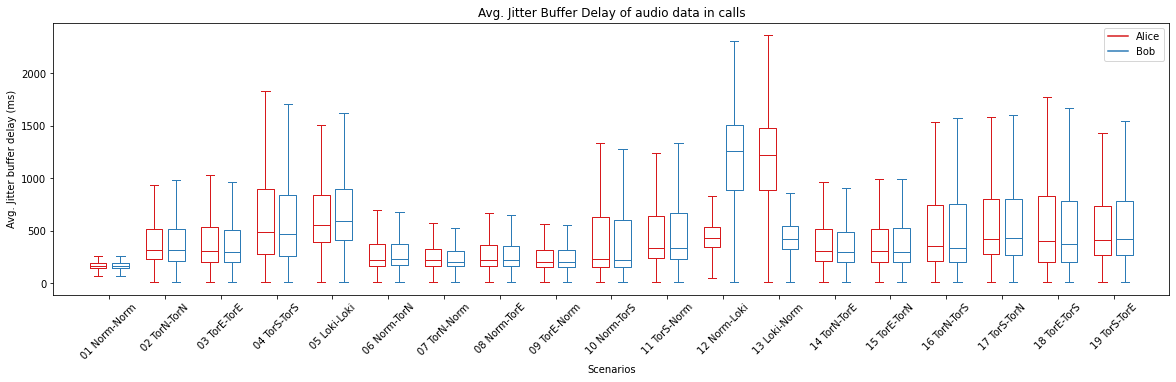

In [4]:
dataA = []
dataB = []
for scenario in hf.scenarios:
  s = scenario["scenario"]
  a = scenario["alice"]
  b = scenario["bob"]
  dataA.append(df.loc[(df["scenario"] == s) & (df["mediaType"] == "audio") & (df["client"] == a)]["avgJitterBufferDelay"].values * 1000)
  dataB.append(df.loc[(df["scenario"] == s) & (df["mediaType"] == "audio") & (df["client"] == b)]["avgJitterBufferDelay"].values * 1000)
  # Times 1000 to convert to ms.

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)


plt.figure()

bpl = plt.boxplot(dataA, positions=np.array(range(len(dataA)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(dataB, positions=np.array(range(len(dataB)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Alice')
plt.plot([], c='#2C7BB6', label='Bob')
plt.legend()
plt.title("Avg. Jitter Buffer Delay of audio data in calls")
plt.rcParams["figure.figsize"] = [20,5]

plt.xlabel('Scenarios')
ticks = hf.getScenarioLabels(df["scenario"].unique())
plt.xticks(range(0, len(ticks) * 2, 2), ticks, rotation=45)
plt.xlim(-2, len(ticks)*2)

#plt.ylim(0, 2500)
plt.ylabel('Avg. Jitter buffer delay (ms)')


plt.savefig("output_folder/BoxPlotAvgJitterBufferDelayAudio.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/BoxPlotAvgJitterBufferDelayAudio.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()